In [5]:
# Standard libraries
import os
import pickle

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.experimental import enable_iterative_imputer  # Enable experimental features
from sklearn.impute import IterativeImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Excel handling
import openpyxl
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import (
    Alignment, 
    Font, 
    PatternFill, 
    Border, 
    Side
)

LOAD DATA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import os
import pickle

def load_and_preprocess_data():
    # Load data
    train_cat = pd.read_excel('widsdatathon2025/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx')
    train_quant = pd.read_excel('widsdatathon2025/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
    test_cat = pd.read_excel('widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx')
    test_quant = pd.read_excel('widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx')
    
    # Merge datasets
    train_data = pd.merge(train_cat, train_quant, on='participant_id', how='inner')
    test_data = pd.merge(test_cat, test_quant, on='participant_id', how='inner')
    
    # Drop unnecessary columns
    drop_cols=["Basic_Demos_Enroll_Year", "PreInt_Demos_Fam_Child_Ethnicity",
               "Basic_Demos_Study_Site", "Barratt_Barratt_P1_Edu", 
               "Barratt_Barratt_P1_Occ", "Barratt_Barratt_P2_Edu",
               "Barratt_Barratt_P2_Occ", "MRI_Track_Scan_Location"]
    train_data = train_data.drop(columns=drop_cols, errors='ignore')
    test_data = test_data.drop(columns=drop_cols, errors='ignore')
    
    # Create target variables based on domain knowledge
    train_data['ADHD_Outcome'] = (train_data['SDQ_SDQ_Hyperactivity'] > 7).astype(int)
    
    # This is a placeholder - replace with actual logic for determining sex
    if 'Sex_F' not in train_data.columns:
        # Example: using a hypothetical column that might indicate sex
        # train_data['Sex_F'] = train_data['some_gender_column'].map({'F': 1, 'M': 0})
        train_data['Sex_F'] = np.random.randint(0, 2, size=len(train_data))
    
    # Handle missing values
    numerical_cols = train_data.select_dtypes(include=['number']).columns.drop(['ADHD_Outcome', 'Sex_F'], errors='ignore')
    iter_imputer = IterativeImputer()
    
    train_data[numerical_cols] = iter_imputer.fit_transform(train_data[numerical_cols])
    test_data[numerical_cols] = iter_imputer.transform(test_data[numerical_cols])
    
    # Save preprocessed data
    os.makedirs('processed_data', exist_ok=True)
    train_data.to_csv('processed_data/train_data.csv', index=False)
    test_data.to_csv('processed_data/test_data.csv', index=False)
    
    # Save imputer for future use
    with open('processed_data/iter_imputer.pkl', 'wb') as f:
        pickle.dump(iter_imputer, f)
    
    return train_data, test_data

train_data, test_data = load_and_preprocess_data()

PREPROCESSING

In [2]:
# Drop  unnecessary columns if they exist
drop_cols=["Basic_Demos_Enroll_Year","PreInt_Demos_Fam_Child_Ethnicity","Basic_Demos_Study_Site","Barratt_Barratt_P1_Edu","Barratt_Barratt_P1_Occ","Barratt_Barratt_P2_Edu","Barratt_Barratt_P2_Occ","MRI_Track_Scan_Location"]
train_data=train_data.drop(drop_cols,errors='ignore',axis=1)
train_data.shape

(1213, 22)

In [3]:
test_data=test_data.drop(columns=drop_cols,errors='ignore',axis=1)
test_data.shape

(304, 20)

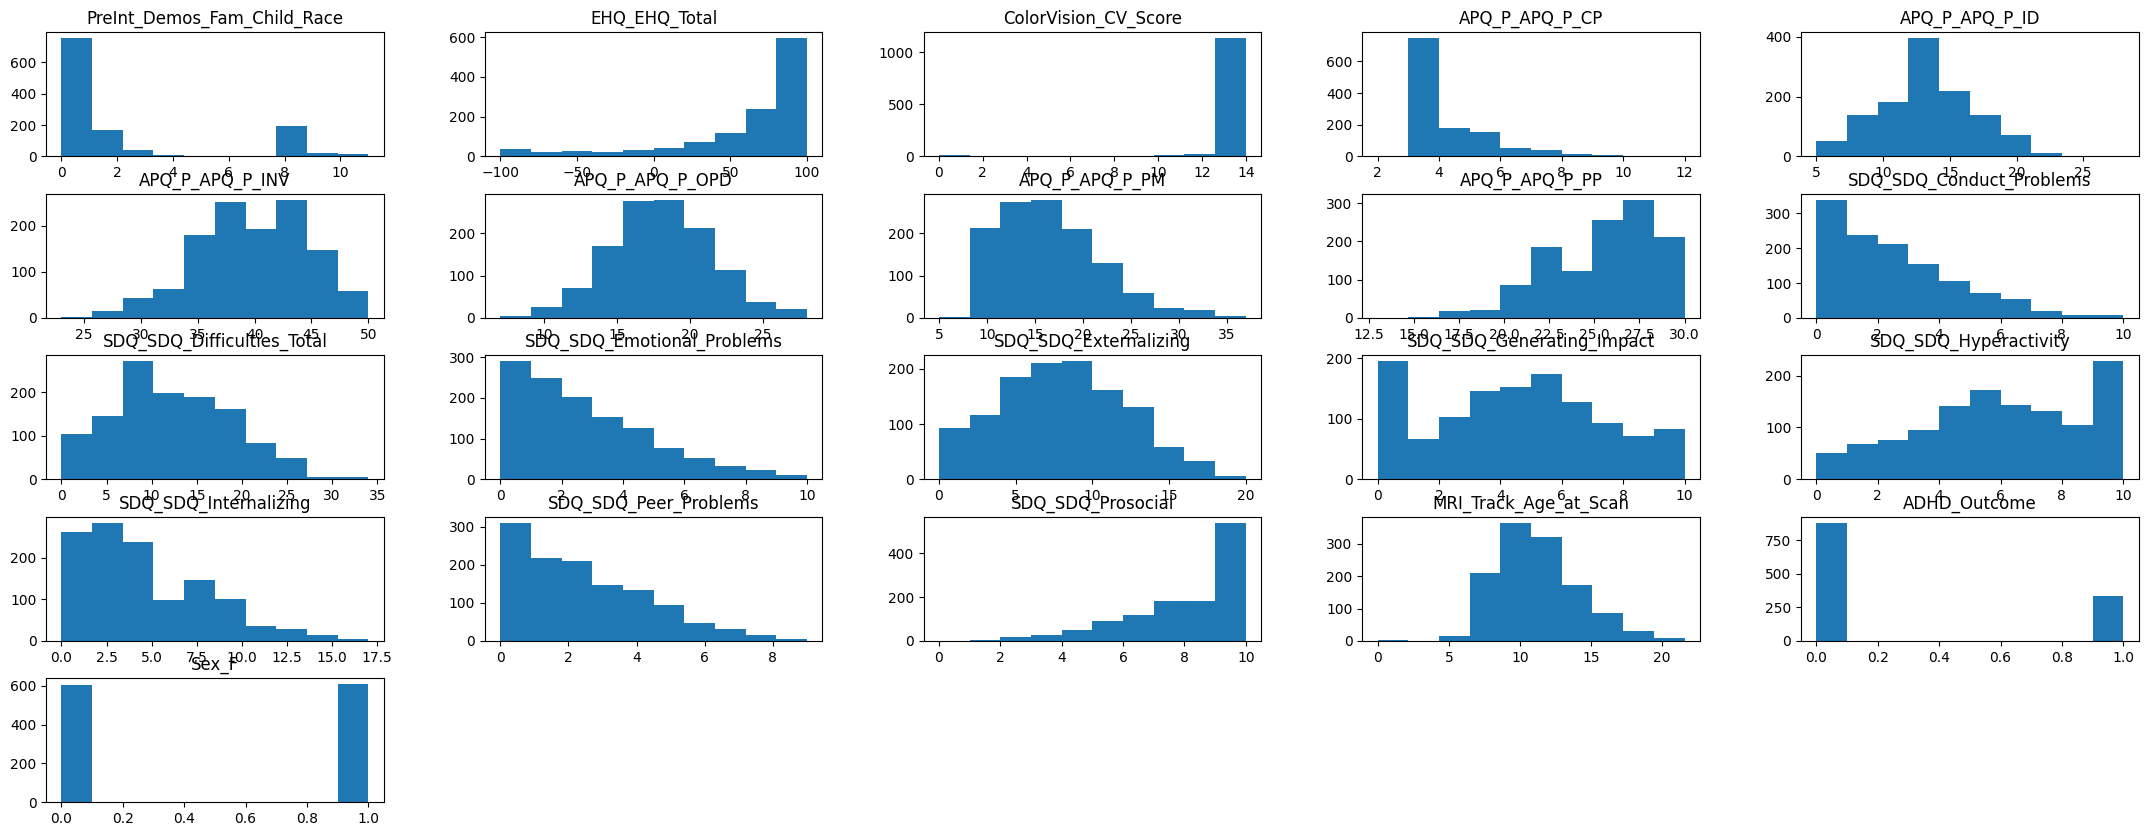

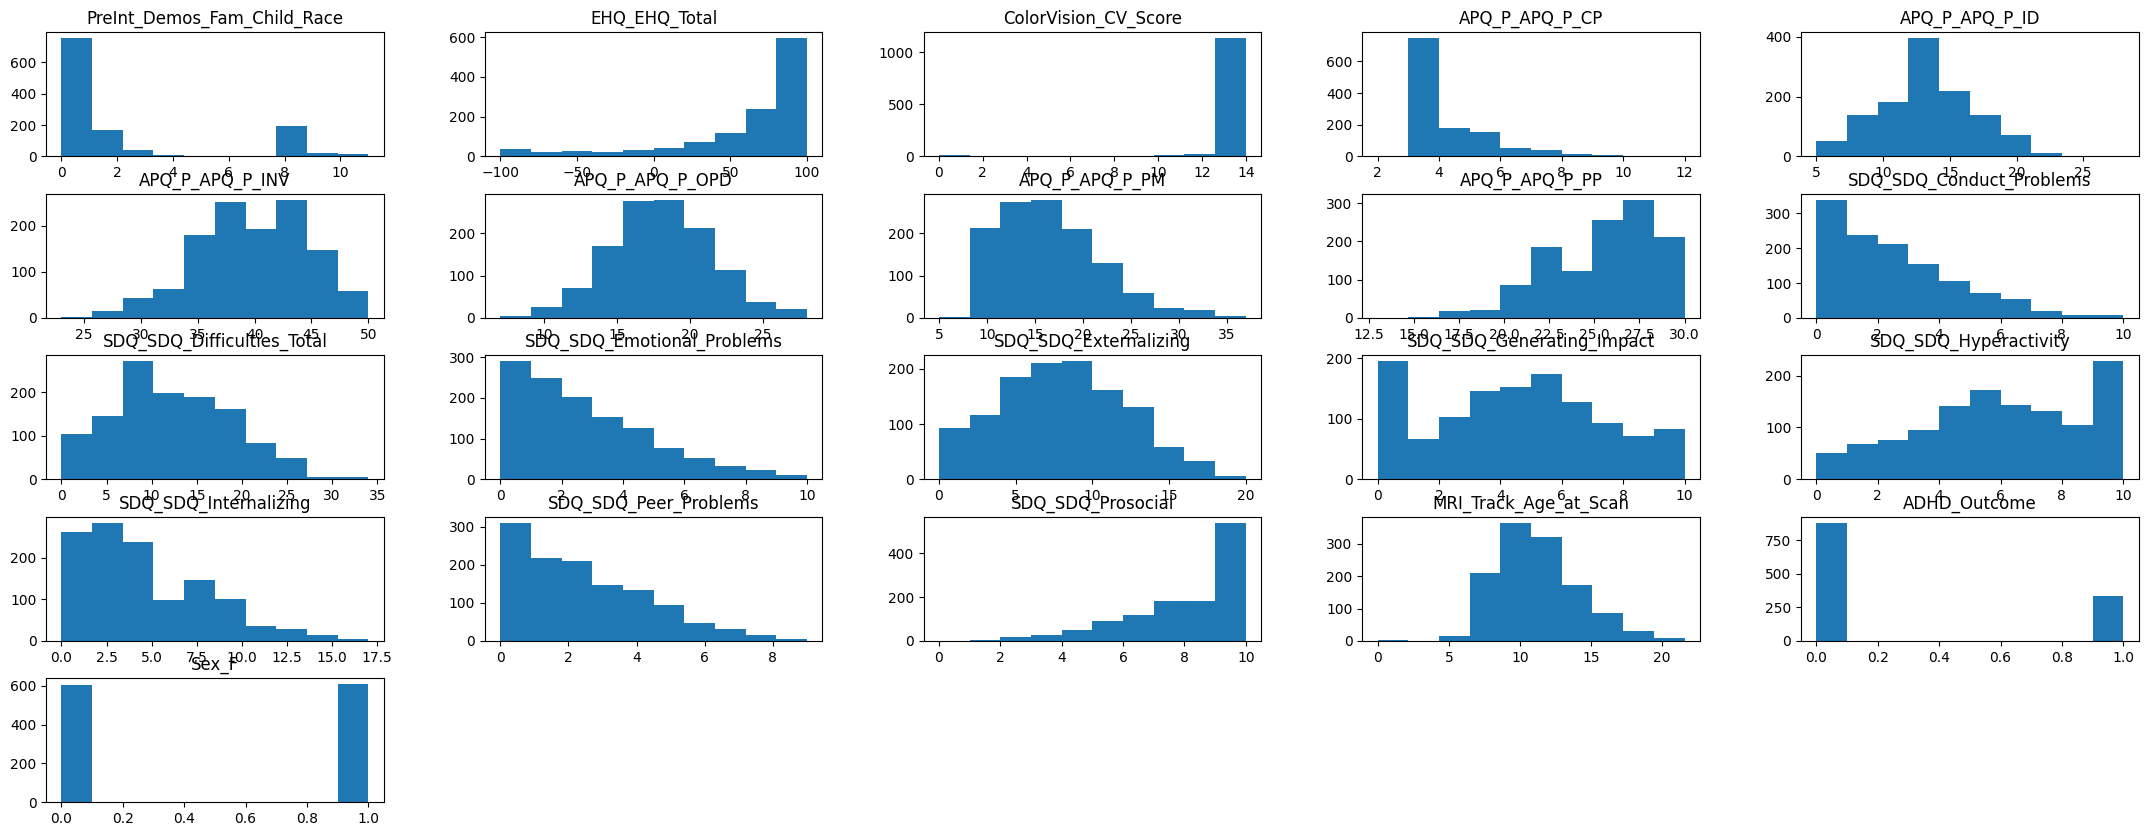

In [6]:
import matplotlib.pyplot as plt

train_data.hist(figsize=(27, 10), bins=10, grid=False)
plt.show()
train_data.hist(figsize=(27, 10), bins=10, grid=False)
plt.show()

<Axes: >

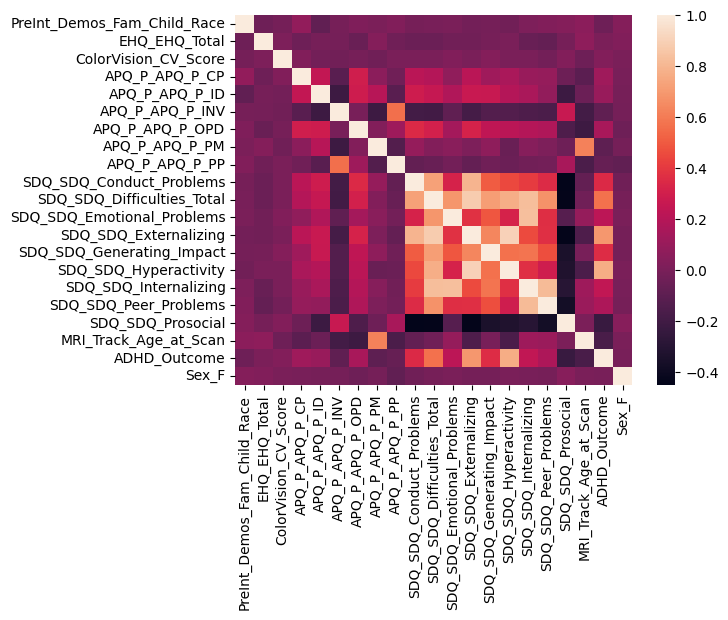

In [7]:
#Check for correlation
corr_train = train_data.select_dtypes(include=['number']).corr()
sns.heatmap(corr_train)
#Drop Basic_Demos_Study_Site ,Barratt_P1_Edu, Barratt_P1_Occ, Barratt_P2_Edu, Barratt_P2_Occ,MRI_Track_Scan_Location

In [8]:
#Check for missing values and impute
test_data.isnull().sum()
train_data.isnull().sum()


participant_id                 0
PreInt_Demos_Fam_Child_Race    0
EHQ_EHQ_Total                  0
ColorVision_CV_Score           0
APQ_P_APQ_P_CP                 0
APQ_P_APQ_P_ID                 0
APQ_P_APQ_P_INV                0
APQ_P_APQ_P_OPD                0
APQ_P_APQ_P_PM                 0
APQ_P_APQ_P_PP                 0
SDQ_SDQ_Conduct_Problems       0
SDQ_SDQ_Difficulties_Total     0
SDQ_SDQ_Emotional_Problems     0
SDQ_SDQ_Externalizing          0
SDQ_SDQ_Generating_Impact      0
SDQ_SDQ_Hyperactivity          0
SDQ_SDQ_Internalizing          0
SDQ_SDQ_Peer_Problems          0
SDQ_SDQ_Prosocial              0
MRI_Track_Age_at_Scan          0
ADHD_Outcome                   0
Sex_F                          0
dtype: int64

In [9]:
#Impute missing values- IMPORTANT
# Identify numerical and categorical columns
numerical_cols = train_data.select_dtypes(include=['number']).columns
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

# Using Iterative Imputer (like regression-based imputation)
iter_imputer = IterativeImputer()
train_data[numerical_cols] = iter_imputer.fit_transform(train_data[numerical_cols])

train_data.isnull().sum()


participant_id                 0
PreInt_Demos_Fam_Child_Race    0
EHQ_EHQ_Total                  0
ColorVision_CV_Score           0
APQ_P_APQ_P_CP                 0
APQ_P_APQ_P_ID                 0
APQ_P_APQ_P_INV                0
APQ_P_APQ_P_OPD                0
APQ_P_APQ_P_PM                 0
APQ_P_APQ_P_PP                 0
SDQ_SDQ_Conduct_Problems       0
SDQ_SDQ_Difficulties_Total     0
SDQ_SDQ_Emotional_Problems     0
SDQ_SDQ_Externalizing          0
SDQ_SDQ_Generating_Impact      0
SDQ_SDQ_Hyperactivity          0
SDQ_SDQ_Internalizing          0
SDQ_SDQ_Peer_Problems          0
SDQ_SDQ_Prosocial              0
MRI_Track_Age_at_Scan          0
ADHD_Outcome                   0
Sex_F                          0
dtype: int64

In [10]:
#$ Prepare data for modeling
X = train_data.drop(["participant_id", "ADHD_Outcome", "Sex_F"], axis=1, errors='ignore')
y = train_data[["ADHD_Outcome", "Sex_F"]]

# Create train/validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, 
    stratify=y
)

In [11]:
#  Define preprocessing steps
numerical_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ], remainder='passthrough')

In [12]:
# Create and train initial model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(
        RandomForestClassifier(n_estimators=100, random_state=42)
    ))
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['PreInt_Demos_Fam_Child_Race', 'EHQ_EHQ_Total', 'ColorVision_CV_Score',
       'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
       'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
       'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
       'S...'SDQ_SDQ_Externalizing',
       'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
       'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial',
       'MRI_Track_Age_at_Scan'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)))])

In [13]:
#Evaluate initial model
def custom_weighted_f1(y_true, y_pred):
    # Convert to arrays if they're DataFrames
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
        
    # Separate predictions
    adhd_true, sex_true = y_true[:, 0], y_true[:, 1]
    adhd_pred, sex_pred = y_pred[:, 0], y_pred[:, 1]
    
    # Calculate standard F1 scores
    adhd_f1 = f1_score(adhd_true, adhd_pred, average='binary')
    sex_f1 = f1_score(sex_true, sex_pred, average='binary')
    
    # Calculate F1 score specifically for female ADHD cases
    female_adhd_mask = (sex_true == 1) & (adhd_true == 1)
    female_adhd_pred = adhd_pred[female_adhd_mask]
    female_adhd_true = adhd_true[female_adhd_mask]
    
    # Double weight female ADHD F1 score in the average
    if len(female_adhd_true) > 0:
        female_adhd_f1 = f1_score(female_adhd_true, female_adhd_pred, average='binary')
        # Apply 2x weight for female ADHD in the final score
        final_score = (adhd_f1 + sex_f1 + 2*female_adhd_f1) / 4
    else:
        final_score = (adhd_f1 + sex_f1) / 2
    
    return final_score

y_pred = model.predict(X_val)
print(f"Initial model validation F1 score: {custom_weighted_f1(y_val.values, y_pred)}")

Initial model validation F1 score: 0.875


In [14]:
#  Calculate class weights
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for both target variables
adhd_weights = compute_class_weight('balanced', classes=np.unique(y_train['ADHD_Outcome']), 
                                   y=y_train['ADHD_Outcome'])
sex_weights = compute_class_weight('balanced', classes=np.unique(y_train['Sex_F']), 
                                  y=y_train['Sex_F'])

# Create dictionaries for class weights
adhd_weight_dict = {i: w for i, w in zip(np.unique(y_train['ADHD_Outcome']), adhd_weights)}
sex_weight_dict = {i: w for i, w in zip(np.unique(y_train['Sex_F']), sex_weights)}
print("Class weights calculated")

Class weights calculated


In [15]:
#  Define hyperparameter tuning 
param_grid = {
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__max_depth': [None, 10],
    'classifier__estimator__min_samples_split': [2, 5],
}

# Create a new model instance for grid search
grid_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(
        RandomForestClassifier(class_weight='balanced', random_state=42)
    ))
])

In [16]:
# : Run grid search (this may take time)
grid_search = GridSearchCV(
    grid_model, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1
)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Best parameters: {'classifier__estimator__max_depth': 10, 'classifier__estimator__min_samples_split': 5, 'classifier__estimator__n_estimators': 200}


In [17]:
#  Feature importance analysis (fixed)

X_encoded = best_model.named_steps['preprocessor'].transform(X_train)

# Get feature names safely
if categorical_features.size > 0:
    try:
        cat_encoder = best_model.named_steps['preprocessor'].transformers_[1][1]
        cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
        feature_names = numerical_features.tolist() + list(cat_feature_names)
    except (NotFittedError, AttributeError):
        print("Warning: Could not get transformed feature names")
        feature_names = [f"feature_{i}" for i in range(X_encoded.shape[1])]
else:
    feature_names = numerical_features.tolist()

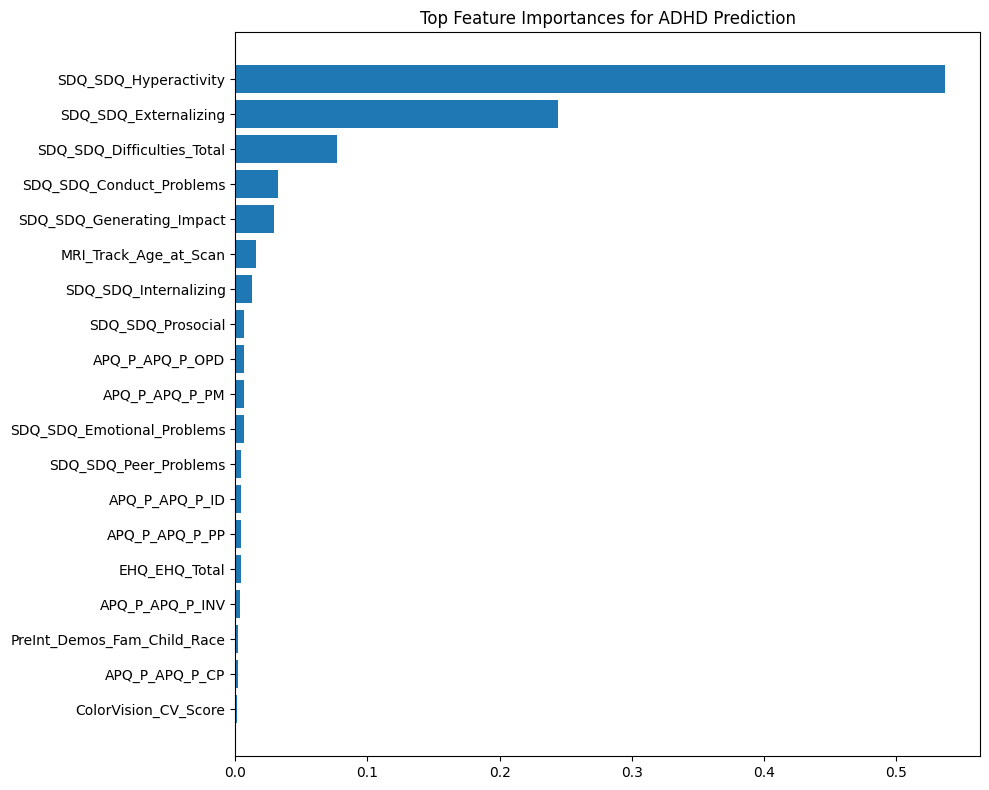

In [18]:
# Plot feature importance
importances = best_model.named_steps['classifier'].estimators_[0].feature_importances_
if len(importances) > len(feature_names):
    # Handle mismatch in lengths
    importances = importances[:len(feature_names)]
elif len(importances) < len(feature_names):
    feature_names = feature_names[:len(importances)]

# Plot top 20 features (or fewer if we have less)
n_features = min(20, len(importances))
indices = np.argsort(importances)[-n_features:]

plt.figure(figsize=(10, 8))
plt.title('Top Feature Importances for ADHD Prediction')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.tight_layout()
plt.show()

In [19]:
# Generate submission
X_test = test_data.drop(['participant_id'], axis=1, errors='ignore')
test_preds = best_model.predict(X_test)

submission = pd.DataFrame({
    'participant_id': test_data['participant_id'],
    'ADHD_Outcome': test_preds[:, 0],
    'Sex_F': test_preds[:, 1]
})

submission.to_csv('submission.csv', index=False)
print("Submission saved to submission.csv")

Submission saved to submission.csv
